In [95]:
import numpy as np
import pandas as pd
import os
import re
import json
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tmdb/tmdb-movie-metadata")

print("Path to dataset files:", path)

100%|██████████| 8.89M/8.89M [00:00<00:00, 80.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2


In [3]:
# Dosya yollarınızı belirtin:
movies_path = "/root/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2/tmdb_5000_movies.csv"
credits_path = "/root/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2/tmdb_5000_credits.csv"

# CSV dosyalarını pandas ile okuyalım:
movies = pd.read_csv(movies_path)
credits = pd.read_csv(credits_path)

In [4]:
# Veri setlerinin ilk birkaç satırına göz atalım:
print("Movies dataset (First 5 Columns):")
movies.head()

Movies dataset (First 5 Columns):


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
print("\nCredits dataset (First 5 Columns):")
credits.head()


Credits dataset (First 5 Columns):


,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
movies = movies.dropna()
credits = credits.dropna()

In [6]:
# "id" sütunu üzerinden veri setlerini birleştirelim:
tmdb_df = movies.merge(credits, on="title")

# Birleştirilmiş veri setinin boyutuna ve ilk satırlarına bakalım:
print("Birleştirilmiş veri seti boyutu:", tmdb_df.shape)
tmdb_df.head()

Birleştirilmiş veri seti boyutu: (4809, 23)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [7]:
# Eksik değerlerin kontrolü:
print("Null Values:")
print(tmdb_df.isnull().sum())

# Temel istatistiksel özet:
print("\nDescriptive Statistics:")
tmdb_df.describe()

Null Values:
budget                     0
genres                     0
homepage                3096
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                       0
crew                       0
dtype: int64

Descriptive Statistics:


,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id
count,4.809000e+03,4809.000000,4809.000000,4.809000e+03,4807.000000,4809.000000,4809.000000,4809.000000
mean,2.902780e+07,57120.571429,21.491664,8.227511e+07,106.882255,6.092514,690.331670,57120.571429
std,4.070473e+07,88653.369849,31.803366,1.628379e+08,22.602535,1.193989,1234.187111,88653.369849
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000
25%,7.800000e+05,9012.000000,4.667230,0.000000e+00,94.000000,5.600000,54.000000,9012.000000
50%,1.500000e+07,14624.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14624.000000
75%,4.000000e+07,58595.000000,28.350529,9.291317e+07,118.000000,6.800000,737.000000,58595.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000


In [8]:
import ast

# 'genres' sütunundaki string ifadeleri sözlük/list tipine çevirme fonksiyonu:
def parse_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres_list]
    except:
        return []

# Yeni bir sütun oluşturarak, her filmin genre bilgilerini liste halinde saklayalım:
tmdb_df['genres_parsed'] = tmdb_df['genres'].apply(parse_genres)

# Örnek sonuç:
print(tmdb_df[['title', 'genres_parsed']].head())

                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                   genres_parsed  
0  [Action, Adventure, Fantasy, Science Fiction]  
1                   [Adventure, Fantasy, Action]  
2                     [Action, Adventure, Crime]  
3               [Action, Crime, Drama, Thriller]  
4           [Action, Adventure, Science Fiction]  


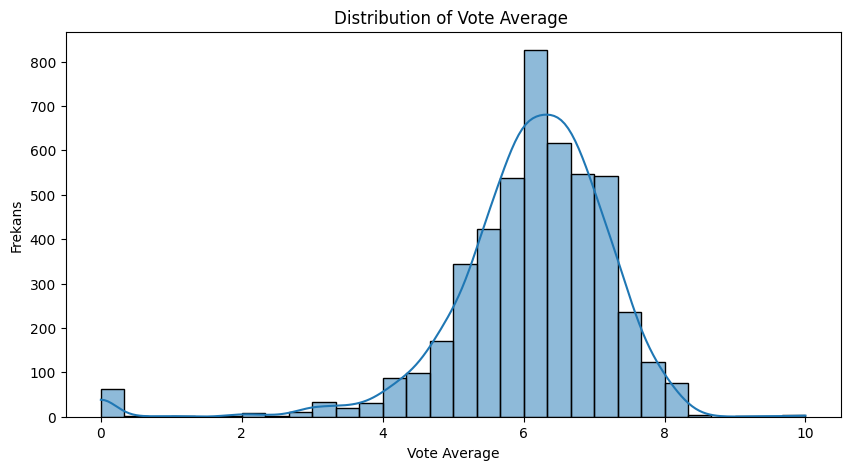

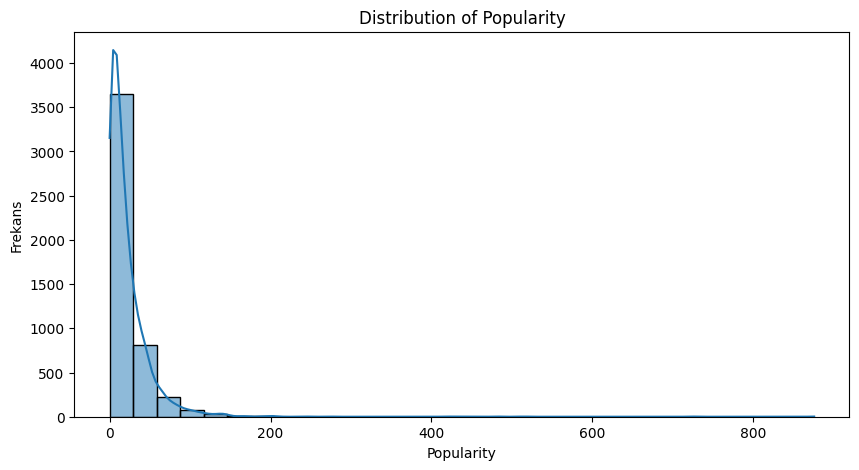

In [10]:
# Oy ortalaması dağılımı:
plt.figure(figsize=(10,5))
sns.histplot(tmdb_df['vote_average'], bins=30, kde=True)
plt.title("Distribution of Vote Average ")
plt.xlabel("Vote Average")
plt.ylabel("Frekans")
plt.show()

# Popülarite dağılımı:
plt.figure(figsize=(10,5))
sns.histplot(tmdb_df['popularity'], bins=30, kde=True)
plt.title("Distribution of Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frekans")
plt.show()

In [11]:
# 'release_date' sütununu datetime tipine çevirelim:
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], errors='coerce')

# Yıl bilgisini yeni bir sütun olarak ekleyelim:
tmdb_df['release_year'] = tmdb_df['release_date'].dt.year

# İlk örnek:
print(tmdb_df[['title', 'release_date', 'release_year']].head())

                                      title release_date  release_year
0                                    Avatar   2009-12-10        2009.0
1  Pirates of the Caribbean: At World's End   2007-05-19        2007.0
2                                   Spectre   2015-10-26        2015.0
3                     The Dark Knight Rises   2012-07-16        2012.0
4                               John Carter   2012-03-07        2012.0


# Preprocessing the TMDB Dataset

In this section, we perform data preprocessing to remove unnecessary columns and prepare our data for further analysis. We remove columns that are not directly useful for building a recommendation model. For example, columns like `budget`, `homepage`, and `tagline` typically do not contribute to the recommendation logic and can be removed.

Additionally, you may choose to drop other columns that provide highly specific information (e.g. `production_companies`, `production_countries`, and `spoken_languages`) to simplify the dataset. However, if you plan to use them in future feature engineering or content-based filtering, you might want to keep a copy for further analysis.

In [12]:
columns_to_drop = [
    'budget',                # Financial info that is less relevant for recommendation.
    'homepage',              # Not required for modeling.
    'production_companies',  # Detailed production info, can be dropped or processed separately.
    'production_countries',  # Similar reasoning as above.
    'spoken_languages',      # Language details, can be removed to simplify the dataset.
    'movie_id',
    'popularity',
    'revenue',
    'status',
    'cast',
    'crew'
]

In [13]:
# Drop the columns from the merged dataframe (tmdb_df)
tmdb_df_cleaned = tmdb_df.drop(columns=columns_to_drop)

In [14]:
# Display the columns of the preprocessed dataframe to confirm the unnecessary columns have been removed.
print("Columns in the preprocessed dataset:")
print(tmdb_df_cleaned.columns.tolist())

Columns in the preprocessed dataset:
['genres', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'release_date', 'runtime', 'tagline', 'title', 'vote_average', 'vote_count', 'genres_parsed', 'release_year']


In [15]:
tmdb_df_cleaned.head()

,genres,id,keywords,original_language,original_title,overview,release_date,runtime,tagline,title,vote_average,vote_count,genres_parsed,release_year
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",2009-12-10,162.0,Enter the World of Pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]",2009.0
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",2007-05-19,169.0,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]",2007.0
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,2015-10-26,148.0,A Plan No One Escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]",2015.0
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,2012-07-16,165.0,The Legend Ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]",2012.0
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",2012-03-07,132.0,"Lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]",2012.0


In [16]:
print("Cleaned dataset shape:", tmdb_df_cleaned.shape)

Cleaned dataset shape: (4809, 14)


In [17]:
tmdb_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genres             4809 non-null   object        
 1   id                 4809 non-null   int64         
 2   keywords           4809 non-null   object        
 3   original_language  4809 non-null   object        
 4   original_title     4809 non-null   object        
 5   overview           4806 non-null   object        
 6   release_date       4808 non-null   datetime64[ns]
 7   runtime            4807 non-null   float64       
 8   tagline            3965 non-null   object        
 9   title              4809 non-null   object        
 10  vote_average       4809 non-null   float64       
 11  vote_count         4809 non-null   int64         
 12  genres_parsed      4809 non-null   object        
 13  release_year       4808 non-null   float64       
dtypes: datet

In [18]:
print(tmdb_df_cleaned.isnull().sum())

genres                 0
id                     0
keywords               0
original_language      0
original_title         0
overview               3
release_date           1
runtime                2
tagline              844
title                  0
vote_average           0
vote_count             0
genres_parsed          0
release_year           1
dtype: int64


In [19]:
# Process overview: Fill missing values (if any) and convert to lowercase
tmdb_df_cleaned['overview'] = tmdb_df_cleaned['overview'].fillna("").str.lower()

In [20]:
# Process tagline: Fill missing values (if any) and convert to lowercase
tmdb_df_cleaned['tagline'] = tmdb_df_cleaned['tagline'].fillna("").str.lower()

In [21]:
# Optionally, include vote_average as a string (if you want to weight by it)
tmdb_df_cleaned['vote_average_str'] = tmdb_df_cleaned['vote_average'].astype(str)

In [22]:
tmdb_df_cleaned.isnull().sum()

,0
genres,0
id,0
keywords,0
original_language,0
original_title,0
overview,0
release_date,1
runtime,2
tagline,0
title,0


## Combined Feature String

In this step, instead of creating only the 'keywords_taglines_genres' column, we also add 'overview' (and optionally the string representation of vote_average) to our existing textual information to form a single combined text column. In this way, we obtain a richer representation that simultaneously utilizes the movie's content, synopsis, tags, and genre information.

In [24]:
# Create a new combined feature column by concatenating genres_processed, tagline_processed, overview, and optionally vote_average_str
tmdb_df_cleaned['combined_text'] = (
    tmdb_df_cleaned['genres'] + " " +
    tmdb_df_cleaned['tagline'] + " " +
    tmdb_df_cleaned['overview'] + " " +
    tmdb_df_cleaned['vote_average_str']
)

In [25]:
# Preview the combined feature column
print(tmdb_df_cleaned[['original_title', 'combined_text']].head())

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                       combined_text  
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...  
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...  
2  [{"id": 28, "name": "Action"}, {"id": 12, "nam...  
3  [{"id": 28, "name": "Action"}, {"id": 80, "nam...  
4  [{"id": 28, "name": "Action"}, {"id": 12, "nam...  


# 1. Filtering Top 100 Similar Movies by "keywords", "tagline", "genres"

## 1.1 Cosine Similarity Calculation and Initial Filtering by 'combined_text'

In this phase, we obtain a text matrix using either CountVectorizer or TfidfVectorizer on the combined text column. Then, cosine similarity is computed on this matrix. Cosine similarity calculates the cosine of the angle between two vectors and its value ranges between 0 and 1 (negative values are generally not encountered in text similarity).

The mathematical formula is:

cosine_similarity = (A . B) / (||A|| ||B||)

Here 𝐴 and 𝐵 is the TF/IDF vectors of the texts. Measuring the angle between vectors is highly effective in determining content similarity.





In [26]:
# Create a vectorizer; burada CountVectorizer kullanıyoruz, ancak TfidfVectorizer da tercih edilebilir.
vectorizer = CountVectorizer(stop_words='english')

In [27]:
# Fit and transform the combined text column
combined_matrix = vectorizer.fit_transform(tmdb_df_cleaned['combined_text'])

In [28]:
# Compute cosine similarity matrix on the combined feature matrix
cosine_sim_matrix = cosine_similarity(combined_matrix, combined_matrix)

In [29]:
# Create a reverse mapping from movie title to index for later lookup
indices = pd.Series(tmdb_df_cleaned.index, index=tmdb_df_cleaned['original_title']).drop_duplicates()

In [30]:
# Initial filtering function: Given a movie title, retrieve the top N most similar movies based on cosine similarity
def get_initial_recommendations(title, top_n=100):
    if title not in indices:
        return "Title not found in dataset."
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    # Sort movies by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Exclude the movie itself (first element) and select top_n movies
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return tmdb_df_cleaned.iloc[movie_indices]

In [37]:
initial_recs = get_initial_recommendations("Iron Man", top_n=100)
initial_recs[['original_title', 'release_year', 'vote_average', 'keywords', 'tagline']].head(10)

,original_title,release_year,vote_average,keywords,tagline
4407,The Helix... Loaded,2005.0,4.8,[],
31,Iron Man 3,2013.0,6.8,"[{""id"": 949, ""name"": ""terrorist""}, {""id"": 5597...",unleash the power behind the armor.
4350,Gojira ni-sen mireniamu,1999.0,5.9,"[{""id"": 233, ""name"": ""japan""}, {""id"": 1299, ""n...",get ready to crumble.
1192,Small Soldiers,1998.0,6.2,"[{""id"": 3599, ""name"": ""defense industry""}, {""i...","the few, the proud, and the small."
322,The Fifth Element,1997.0,7.3,"[{""id"": 402, ""name"": ""clone""}, {""id"": 444, ""na...",there is no future without it.
4676,Mad Max,1979.0,6.6,"[{""id"": 473, ""name"": ""chain""}, {""id"": 1009, ""n...",the maximum force of the future
931,Race to Witch Mountain,2009.0,5.5,"[{""id"": 1612, ""name"": ""spacecraft""}, {""id"": 32...",the race is on
922,Knowing,2009.0,5.9,"[{""id"": 843, ""name"": ""cataclysm""}, {""id"": 4950...",knowing is everything...
33,X-Men: The Last Stand,2006.0,6.3,"[{""id"": 1852, ""name"": ""mutant""}, {""id"": 8828, ...",take a stand
0,Avatar,2009.0,7.2,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",enter the world of pandora.


## 1.2 Cosine Similarity and Initial Filtering by 'keywords', 'genre' and 'tagline'

In [38]:
tmdb_df_cleaned.genres[0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [39]:
tmdb_df_cleaned.keywords[0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [40]:
tmdb_df_cleaned.tagline[0]

'enter the world of pandora.'

In [41]:
tmdb_keywords_tagline_genres = tmdb_df_cleaned[['id', 'original_title']]

In [42]:
tmdb_keywords_tagline_genres.head()

,id,original_title
0,19995,Avatar
1,285,Pirates of the Caribbean: At World's End
2,206647,Spectre
3,49026,The Dark Knight Rises
4,49529,John Carter


In [43]:
tmdb_keywords_tagline_genres["genres_combined"] = tmdb_df_cleaned.genres.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
tmdb_keywords_tagline_genres["keywords_combined"] = tmdb_df_cleaned.keywords.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
tmdb_keywords_tagline_genres["tagline_processed"] = tmdb_df_cleaned.tagline.apply(lambda row: row.lower())

In [44]:
tmdb_keywords_tagline_genres["keywords_taglines_genres"] = tmdb_keywords_tagline_genres.apply((lambda row: ' ' . join([row.genres_combined, row.keywords_combined, row.tagline_processed])), axis=1)

In [45]:
tmdb_keywords_tagline_genres.head()

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,19995,Avatar,action adventure fantasy science fiction,culture clash future space war space colony so...,enter the world of pandora.,action adventure fantasy science fiction cultu...
1,285,Pirates of the Caribbean: At World's End,adventure fantasy action,ocean drug abuse exotic island east india trad...,"at the end of the world, the adventure begins.",adventure fantasy action ocean drug abuse exot...
2,206647,Spectre,action adventure crime,spy based on novel secret agent sequel mi6 bri...,a plan no one escapes,action adventure crime spy based on novel secr...
3,49026,The Dark Knight Rises,action crime drama thriller,dc comics crime fighter terrorist secret ident...,the legend ends,action crime drama thriller dc comics crime fi...
4,49529,John Carter,action adventure science fiction,based on novel mars medallion space travel pri...,"lost in our world, found in another.",action adventure science fiction based on nove...


In [46]:
tmdb_keywords_tagline_genres = tmdb_keywords_tagline_genres.sort_values("id")
tmdb_keywords_tagline_genres = tmdb_keywords_tagline_genres.reset_index(drop=True)

In [47]:
tmdb_keywords_tagline_genres.head()

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,5,Four Rooms,crime comedy,hotel new year's eve witch bet hotel room sper...,twelve outrageous guests. four scandalous requ...,crime comedy hotel new year's eve witch bet ho...
1,11,Star Wars,adventure action science fiction,android galaxy hermit death star lightsaber je...,"a long time ago in a galaxy far, far away...",adventure action science fiction android galax...
2,12,Finding Nemo,animation family,father son relationship harbor underwater fish...,"there are 3.7 trillion fish in the ocean, they...",animation family father son relationship harbo...
3,13,Forrest Gump,comedy drama romance,vietnam veteran hippie mentally disabled runni...,"the world will never be the same, once you've ...",comedy drama romance vietnam veteran hippie me...
4,14,American Beauty,drama,male nudity female nudity adultery midlife cri...,look closer.,drama male nudity female nudity adultery midli...


In [48]:
tmdb_keywords_tagline_genres.keywords_taglines_genres

,keywords_taglines_genres
0,crime comedy hotel new year's eve witch bet ho...
1,adventure action science fiction android galax...
2,animation family father son relationship harbo...
3,comedy drama romance vietnam veteran hippie me...
4,drama male nudity female nudity adultery midli...
...,...
4804,horror the hot spot where satan's waitin'.
4805,comedy family drama it’s better to stand out ...
4806,thriller drama christian film sex trafficking ...
4807,family


In [49]:
vectorizer = CountVectorizer(stop_words='english')
vectorized = vectorizer.fit_transform(tmdb_keywords_tagline_genres.keywords_taglines_genres)

In [50]:
vectorized.toarray().shape

(4809, 9220)

In [51]:
vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [52]:
top10words = vectorizer.get_feature_names_out()
top10words

array(['000', '007', '05', ..., '最后的舞者', '绝地奶霸', '超级妈妈'], dtype=object)

In [53]:
top_freqs = vectorized.sum(axis=0).A1 # sum matrix into a 1D NumPy array
top_freqs

array([17,  6,  2, ...,  1,  1,  1])

In [54]:
sorted_indices = top_freqs.argsort()[::-1] # Sort the words by frequency in descending order
top10words = [top10words[idx] for idx in sorted_indices]
top_freqs = top_freqs[sorted_indices]

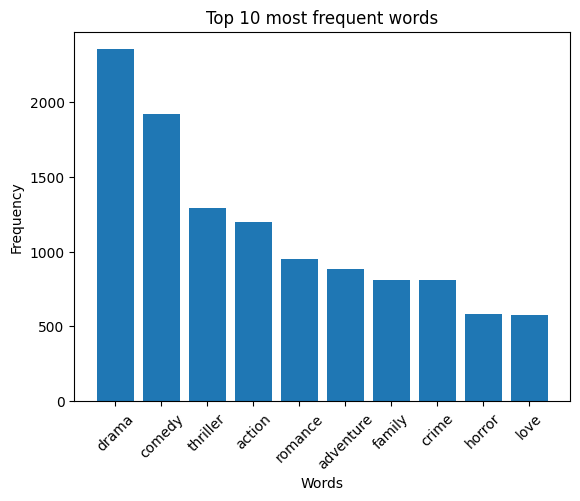

In [55]:
plt.bar(top10words[:10], top_freqs[:10])
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 most frequent words')
plt.show()

In [56]:
word_freqs = {}
for x in list(pd.DataFrame([top10words, top_freqs]).transpose().apply(lambda row: {row[0]: row[1]}, axis=1)):
    for key, val in x.items():
        word_freqs[key] = val

(np.float64(-0.5), np.float64(999.5), np.float64(399.5), np.float64(-0.5))

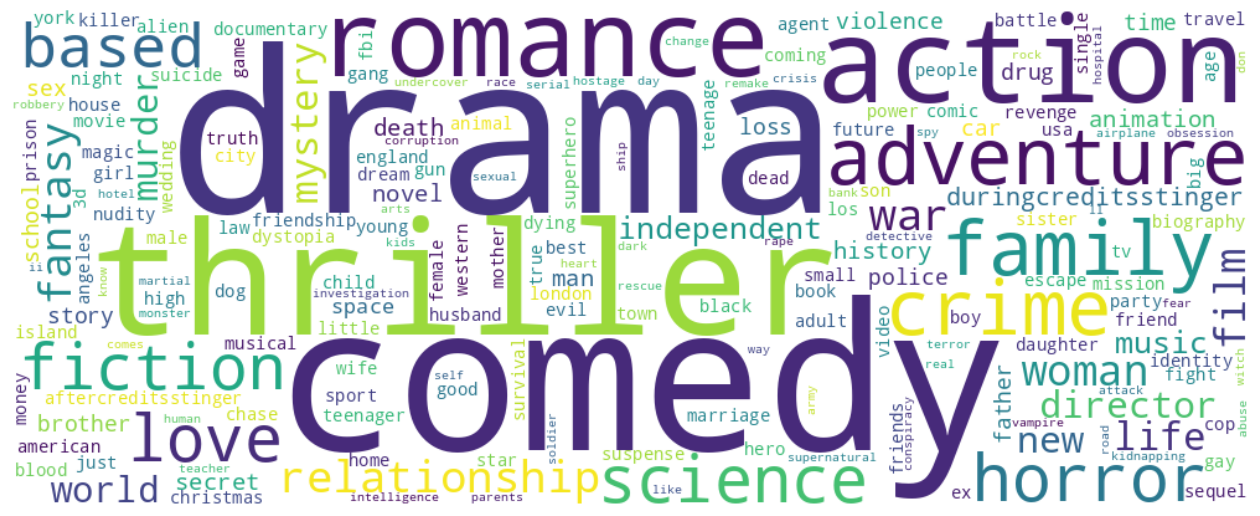

In [57]:
word_cloud = wordcloud.WordCloud(width=1000, height=400, background_color='white')
word_cloud.generate_from_frequencies(word_freqs)
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')

Now we use consine similarity to find the similarity. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. It is often used in natural language processing and information retrieval to measure how similar two documents are based on their content. The value of cosine similarity ranges from -1 to 1, with 1 indicating that the two vectors are identical and 0 indicating that they are completely dissimilar. Higher values of cosine similarity indicate greater similarity between the vectors.


The formula for cosine similarity between two vectors A and B can be expressed as:

cosine_similarity = (A . B) / (||A|| ||B||)

where A . B represents the dot product of A and B, and ||A|| and ||B|| represent the magnitudes of A and B, respectively.

In [58]:
cosine_results = cosine_similarity(vectorized.toarray())
pd.DataFrame(cosine_results)

,0,1,2,3,4,5,6,7,8,9,...,4799,4800,4801,4802,4803,4804,4805,4806,4807,4808
0,1.000000,0.000000,0.000000,0.024419,0.050016,0.043581,0.083388,0.024419,0.075485,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.065372,0.056614,0.000000,0.0
1,0.000000,1.000000,0.000000,0.025777,0.026398,0.046004,0.198053,0.051554,0.039841,0.054133,...,0.000000,0.000000,0.070491,0.000000,0.122988,0.0,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,1.000000,0.096449,0.049386,0.021517,0.000000,0.000000,0.037268,0.025318,...,0.000000,0.000000,0.000000,0.000000,0.076696,0.0,0.064550,0.000000,0.158114,0.0
3,0.024419,0.025777,0.096449,1.000000,0.071449,0.062257,0.059561,0.046512,0.179721,0.000000,...,0.000000,0.000000,0.063596,0.152499,0.036986,0.0,0.186772,0.053916,0.152499,0.0
4,0.050016,0.026398,0.049386,0.071449,1.000000,0.021253,0.020332,0.047633,0.073621,0.000000,...,0.000000,0.000000,0.032564,0.156174,0.000000,0.0,0.127515,0.110432,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.447214,0.298142,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0
4805,0.065372,0.000000,0.064550,0.186772,0.127515,0.055556,0.000000,0.062257,0.096225,0.000000,...,0.000000,0.000000,0.085126,0.408248,0.099015,0.0,1.000000,0.144338,0.408248,0.0
4806,0.056614,0.000000,0.000000,0.053916,0.110432,0.048113,0.046029,0.107833,0.083333,0.000000,...,0.000000,0.000000,0.073721,0.353553,0.000000,0.0,0.144338,1.000000,0.000000,0.0
4807,0.000000,0.000000,0.158114,0.152499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.242536,0.0,0.408248,0.000000,1.000000,0.0


Now that we have the cosine similarity table for each movie, we can retrieve the movie ID that the user just watched and find its similarity with other movies.

In [59]:
[result for result in tmdb_keywords_tagline_genres["original_title"] if 'iron' in result.lower()]

['Iron Man',
 'The Man in the Iron Mask',
 'Gridiron Gang',
 'Iron Man 2',
 'The Iron Giant',
 'Ironclad',
 'Iron Man 3',
 'The Iron Lady',
 'The Man with the Iron Fists']

In [60]:
movie_title = "Iron Man"
movie_index = [index for index, x in enumerate(tmdb_keywords_tagline_genres["original_title"] == movie_title) if x == True][0]

In [61]:
movie_index

572

Once we obtain the movie index, we can utilize the cosine_similarity matrix to determine the 100 most similar movies to the movie ID that the user watched.

In [62]:
top_100_movies = sorted(list(enumerate(cosine_results[movie_index])), key=lambda x: x[1], reverse=True)[:100]

In [63]:
top_100_movies[:10]

[(572, np.float64(1.0)),
 (1589, np.float64(0.6761234037828133)),
 (4003, np.float64(0.6696620080077292)),
 (3709, np.float64(0.6335564128181457)),
 (3993, np.float64(0.5963765795456271)),
 (2865, np.float64(0.5863527298559492)),
 (3989, np.float64(0.5749889084999458)),
 (4525, np.float64(0.5649883385169099)),
 (3147, np.float64(0.5493502655735358)),
 (3806, np.float64(0.5303948353054367))]

In [64]:
top_movies = pd.DataFrame(np.squeeze(tmdb_keywords_tagline_genres.values[[np.array(top_100_movies)[:, 0].astype(int)]]), columns=tmdb_keywords_tagline_genres.columns)
top_movies.head(101)

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,1726,Iron Man,action science fiction adventure,middle east arms dealer malibu marvel comic su...,heroes aren't born. they're built.,action science fiction adventure middle east a...
1,10138,Iron Man 2,adventure action science fiction,malibu marvel comic superhero based on comic b...,"it's not the armor that makes the hero, but th...",adventure action science fiction malibu marvel...
2,102899,Ant-Man,science fiction action adventure,marvel comic superhero based on comic book aft...,heroes don't get any bigger.,science fiction action adventure marvel comic ...
3,68721,Iron Man 3,action adventure science fiction,terrorist war on terror tennessee malibu marve...,unleash the power behind the armor.,action adventure science fiction terrorist war...
4,100402,Captain America: The Winter Soldier,action adventure science fiction,washington d.c. future shield marvel comic sup...,in heroes we trust.,action adventure science fiction washington d....
...,...,...,...,...,...,...
95,15158,Phantasm II,action horror science fiction thriller,portal undertaker evil tall man sentinals,the ball is back!,action horror science fiction thriller portal ...
96,20406,Rockaway,action adventure drama,,,action adventure drama
97,29015,The Specials,action comedy,superhero,,action comedy superhero
98,110402,Трудно быть богом,drama science fiction,,,drama science fiction


So we now have the top 100 recommended movie that similar to the one that watched by the user. We can ignore the first actually, because it's the movie that the user wathced itself.

# 2. Filtering Top 50 Movies from the Top 100 Movies based on their vote counts (raitings) using TfidfVectorizer and calculating the Cosine Similarity

To achieve this, we will use the vote average approach, where the Weighted Rating (WR) is calculated using the formula:

Weighted Rating (WR) = (v / (v + m)) * R + (m / (v + m)) * C

We will now create a new dataframe for this purpose.

In [65]:
second_filters = top_movies.merge(tmdb_df_cleaned, on="id", how="inner")

In [66]:
second_filters.head()

,id,original_title_x,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres,genres,keywords,original_language,original_title_y,...,release_date,runtime,tagline,title,vote_average,vote_count,genres_parsed,release_year,vote_average_str,combined_text
0,1726,Iron Man,action science fiction adventure,middle east arms dealer malibu marvel comic su...,heroes aren't born. they're built.,action science fiction adventure middle east a...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...","[{""id"": 539, ""name"": ""middle east""}, {""id"": 61...",en,Iron Man,...,2008-04-30,126.0,heroes aren't born. they're built.,Iron Man,7.4,8776,"[Action, Science Fiction, Adventure]",2008.0,7.4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na..."
1,10138,Iron Man 2,adventure action science fiction,malibu marvel comic superhero based on comic b...,"it's not the armor that makes the hero, but th...",adventure action science fiction malibu marvel...,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...","[{""id"": 8613, ""name"": ""malibu""}, {""id"": 8828, ...",en,Iron Man 2,...,2010-04-28,124.0,"it's not the armor that makes the hero, but th...",Iron Man 2,6.6,6849,"[Adventure, Action, Science Fiction]",2010.0,6.6,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""..."
2,102899,Ant-Man,science fiction action adventure,marvel comic superhero based on comic book aft...,heroes don't get any bigger.,science fiction action adventure marvel comic ...,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...","[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Ant-Man,...,2015-07-14,117.0,heroes don't get any bigger.,Ant-Man,7.0,5880,"[Science Fiction, Action, Adventure]",2015.0,7.0,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""..."
3,68721,Iron Man 3,action adventure science fiction,terrorist war on terror tennessee malibu marve...,unleash the power behind the armor.,action adventure science fiction terrorist war...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 949, ""name"": ""terrorist""}, {""id"": 5597...",en,Iron Man 3,...,2013-04-18,130.0,unleash the power behind the armor.,Iron Man 3,6.8,8806,"[Action, Adventure, Science Fiction]",2013.0,6.8,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
4,100402,Captain America: The Winter Soldier,action adventure science fiction,washington d.c. future shield marvel comic sup...,in heroes we trust.,action adventure science fiction washington d....,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 521, ""name"": ""washington d.c.""}, {""id""...",en,Captain America: The Winter Soldier,...,2014-03-20,136.0,in heroes we trust.,Captain America: The Winter Soldier,7.6,5764,"[Action, Adventure, Science Fiction]",2014.0,7.6,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


In [67]:
weight_averaged_method = second_filters[["id", "original_title_x", "vote_average", "vote_count"]]

In [68]:
tmdb_df_cleaned.head()

,genres,id,keywords,original_language,original_title,overview,release_date,runtime,tagline,title,vote_average,vote_count,genres_parsed,release_year,vote_average_str,combined_text
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"in the 22nd century, a paraplegic marine is di...",2009-12-10,162.0,enter the world of pandora.,Avatar,7.2,11800,"[Action, Adventure, Fantasy, Science Fiction]",2009.0,7.2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha...",2007-05-19,169.0,"at the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[Adventure, Fantasy, Action]",2007.0,6.9,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,a cryptic message from bond’s past sends him o...,2015-10-26,148.0,a plan no one escapes,Spectre,6.3,4466,"[Action, Adventure, Crime]",2015.0,6.3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,following the death of district attorney harve...,2012-07-16,165.0,the legend ends,The Dark Knight Rises,7.6,9106,"[Action, Crime, Drama, Thriller]",2012.0,7.6,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"john carter is a war-weary, former military ca...",2012-03-07,132.0,"lost in our world, found in another.",John Carter,6.1,2124,"[Action, Adventure, Science Fiction]",2012.0,6.1,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


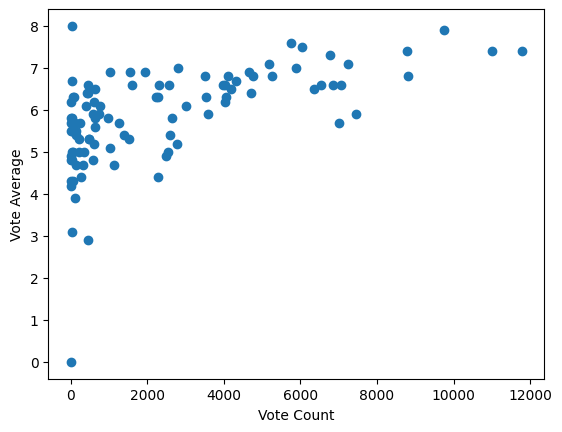

In [69]:
plt.figure()
plt.scatter(weight_averaged_method.vote_count, weight_averaged_method.vote_average)
plt.xlabel('Vote Count')
plt.ylabel('Vote Average')
plt.show()

### Average Movie Ratings

In [70]:
weight_averaged_method['R'] = weight_averaged_method.vote_average
weight_averaged_method.R

,R
0,7.4
1,6.6
2,7.0
3,6.8
4,7.6
...,...
95,6.3
96,5.8
97,5.5
98,6.7


### Mean vote (ratings) across all movies

In [72]:
C = weight_averaged_method.R.mean()
print(C)

5.874


### Number of votes (ratings) received by all movies

In [73]:
weight_averaged_method['v'] = weight_averaged_method.vote_count
weight_averaged_method.v

,v
0,8776
1,6849
2,5880
3,8806
4,5764
...,...
95,94
96,2
97,11
98,41


### Minimum votes (ratings) required for the movie to be considered.

In [75]:
PERCENTAGE = .95 # set to 95%
m = weight_averaged_method.v.quantile(PERCENTAGE)
print(f"{PERCENTAGE * 100}%", "-", m)

95.0% - 7523.899999999996


### Calculate the weighted average ratings using the provided formula.

In [76]:
weight_averaged_method.head()

,id,original_title_x,vote_average,vote_count,R,v
0,1726,Iron Man,7.4,8776,7.4,8776
1,10138,Iron Man 2,6.6,6849,6.6,6849
2,102899,Ant-Man,7.0,5880,7.0,5880
3,68721,Iron Man 3,6.8,8806,6.8,8806
4,100402,Captain America: The Winter Soldier,7.6,5764,7.6,5764


In [77]:
def calculate_WR(query):
    R = query.R
    v = query.v
    return (v / (v + m)) * R + (m / (v + m)) * C

In [78]:
weight_averaged_method["WR"] = weight_averaged_method.apply(calculate_WR, axis=1)

In [79]:
weight_averaged_method.head()

,id,original_title_x,vote_average,vote_count,R,v,WR
0,1726,Iron Man,7.4,8776,7.4,8776,6.695611
1,10138,Iron Man 2,6.6,6849,6.6,6849,6.219955
2,102899,Ant-Man,7.0,5880,7.0,5880,6.367952
3,68721,Iron Man 3,6.8,8806,6.8,8806,6.373351
4,100402,Captain America: The Winter Soldier,7.6,5764,7.6,5764,6.622701


### Sort the values and pick the highest scores to select the top 50 movies for recommendation.

In [80]:
weight_averaged_method = weight_averaged_method.sort_values("WR", ascending=False)
weight_averaged_method.reset_index(drop=True, inplace=True)

In [81]:
top_50_movies = weight_averaged_method.head(50)
top_50_movies

,id,original_title_x,vote_average,vote_count,R,v,WR
0,118340,Guardians of the Galaxy,7.9,9742,7.9,9742,7.017137
1,24428,The Avengers,7.4,11776,7.4,11776,6.805102
2,293660,Deadpool,7.4,10995,7.4,10995,6.780013
3,1726,Iron Man,7.4,8776,7.4,8776,6.695611
4,100402,Captain America: The Winter Soldier,7.6,5764,7.6,5764,6.622701
5,127585,X-Men: Days of Future Past,7.5,6032,7.5,6032,6.597525
6,99861,Avengers: Age of Ultron,7.3,6767,7.3,6767,6.549237
7,271110,Captain America: Civil War,7.1,7241,7.1,7241,6.475255
8,49538,X-Men: First Class,7.1,5181,7.1,5181,6.373957
9,68721,Iron Man 3,6.8,8806,6.8,8806,6.373351


# 3. Filtering Movies based on Content Similarity by 'overview'

In [83]:
contentbased = top_50_movies.merge(tmdb_df_cleaned[["id", "overview"]], on="id", how="inner")[["id", "original_title_x", "overview"]]
contentbased.columns = ["id", "original_title", "overview"]
contentbased.head()

,id,original_title,overview
0,118340,Guardians of the Galaxy,"light years from earth, 26 years after being a..."
1,24428,The Avengers,when an unexpected enemy emerges and threatens...
2,293660,Deadpool,deadpool tells the origin story of former spec...
3,1726,Iron Man,"after being held captive in an afghan cave, bi..."
4,100402,Captain America: The Winter Soldier,after the cataclysmic events in new york with ...


**NOTE: To ensure that the user's watched movie is among the top 50, we will manually add it if it is not already there, as we need its overview for comparison.**

*It appears that the movie is already included, as indicated by the "true" output.*

In [84]:
check_movie_exist = True in list(contentbased.original_title == movie_title)
check_movie_exist

True

*If the movie is not present in the list, we can add it manually.*

In [87]:
add_title = tmdb_df_cleaned[["id", "original_title", "overview"]][tmdb_df_cleaned[["id", "original_title", "overview"]].original_title == movie_title]
add_title

,id,original_title,overview
68,1726,Iron Man,"after being held captive in an afghan cave, bi..."


In [88]:
contentbased.head()

,id,original_title,overview
0,118340,Guardians of the Galaxy,"light years from earth, 26 years after being a..."
1,24428,The Avengers,when an unexpected enemy emerges and threatens...
2,293660,Deadpool,deadpool tells the origin story of former spec...
3,1726,Iron Man,"after being held captive in an afghan cave, bi..."
4,100402,Captain America: The Winter Soldier,after the cataclysmic events in new york with ...


In [89]:
if not check_movie_exist:
    contentbased = pd.concat([contentbased, add_title])
    contentbased = contentbased.reset_index(drop=True)

**NOTE: In this scenario, we need to ensure and eliminate any numbers or symbols from the overview sentences and convert them all to lowercase.**

In [91]:
def func(row):
    text = row.overview.lower()
    text = ' ' . join(re.findall(r"[a-z]+", text))
    return text

In [93]:
contentbased["overview_cleaned"] = contentbased.apply(func, axis=1)
contentbased.head()

,id,original_title,overview,overview_cleaned
0,118340,Guardians of the Galaxy,"light years from earth, 26 years after being a...",light years from earth years after being abduc...
1,24428,The Avengers,when an unexpected enemy emerges and threatens...,when an unexpected enemy emerges and threatens...
2,293660,Deadpool,deadpool tells the origin story of former spec...,deadpool tells the origin story of former spec...
3,1726,Iron Man,"after being held captive in an afghan cave, bi...",after being held captive in an afghan cave bil...
4,100402,Captain America: The Winter Soldier,after the cataclysmic events in new york with ...,after the cataclysmic events in new york with ...


**Proceed with extracting the features**

*The main difference between CountVectorizer and TfidfVectorizer is that CountVectorizer only counts the occurrences of each word in the document, while TfidfVectorizer considers the frequency of a word across all documents. TfidfVectorizer is better at identifying the most important words in a document or a corpus.*

In [96]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_features = tfidf.fit_transform(contentbased.overview_cleaned)

In [97]:
tfidf_features.toarray()

array([[0.25303086, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16593579, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Computing Cosine Similarity between tfidf_features**

In [99]:
cosine_similarity_tables = cosine_similarity(tfidf_features)

In [100]:
pd.DataFrame(cosine_similarity_tables)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.032456,0.000000,0.000000,0.000000,0.000000,0.025201,0.000000,0.046405,0.000000,...,0.086723,0.000000,0.026416,0.000000,0.000000,0.000000,0.027387,0.000000,0.000000,0.028633
1,0.032456,1.000000,0.000000,0.000000,0.068939,0.000000,0.114992,0.012332,0.045644,0.017217,...,0.000000,0.000000,0.046619,0.000000,0.026767,0.000000,0.000000,0.000000,0.000000,0.023625
2,0.000000,0.000000,1.000000,0.000000,0.024825,0.023796,0.000000,0.009240,0.027888,0.000000,...,0.009023,0.000000,0.000000,0.000000,0.000000,0.018037,0.068104,0.021554,0.018747,0.011394
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.101855,0.000000,0.000000,0.100963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013836,0.000000,0.000000
4,0.000000,0.068939,0.024825,0.000000,1.000000,0.017653,0.067803,0.158769,0.033595,0.050468,...,0.063391,0.020109,0.000000,0.000000,0.078810,0.000000,0.016182,0.020553,0.000000,0.022382
5,0.000000,0.000000,0.023796,0.000000,0.017653,1.000000,0.062314,0.073684,0.070076,0.000000,...,0.000000,0.000000,0.027280,0.000000,0.000000,0.019035,0.000000,0.039974,0.000000,0.016373
6,0.025201,0.114992,0.000000,0.101855,0.067803,0.062314,1.000000,0.083024,0.022334,0.066812,...,0.020869,0.023944,0.000000,0.000000,0.000000,0.000000,0.000000,0.030501,0.000000,0.032997
7,0.000000,0.012332,0.009240,0.000000,0.158769,0.073684,0.083024,1.000000,0.013245,0.017697,...,0.039295,0.000000,0.000000,0.000000,0.031333,0.008958,0.021965,0.023157,0.024244,0.000000
8,0.046405,0.045644,0.027888,0.000000,0.033595,0.070076,0.022334,0.013245,1.000000,0.018493,...,0.025787,0.000000,0.026662,0.000000,0.000000,0.037177,0.014739,0.006137,0.000000,0.000000
9,0.000000,0.017217,0.000000,0.100963,0.050468,0.000000,0.066812,0.017697,0.018493,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**Retrieve the movie index that we want to examine from the similarity table.**

*It's worth noting that each row in the table contains the similarities of that particular row to all the available movies in the table.*

In [101]:
movie_index = [index for index, x in enumerate(contentbased["original_title"] == movie_title) if x == True][0]
movie_index

3

In [105]:
top_movies = pd.DataFrame(list(sorted(enumerate(cosine_similarity_tables[movie_index]), key=lambda x: x[1], reverse=True)))
top_movies.columns = ["top_index", "cosine_similarity"]
top_movies.head(15)

,top_index,cosine_similarity
0,3,1.000000
1,15,0.133516
2,6,0.101855
3,9,0.100963
4,10,0.036396
5,22,0.033701
6,19,0.031284
7,47,0.013836
8,0,0.000000
9,1,0.000000


In [106]:
top_15_movies = pd.DataFrame(contentbased[["id", "original_title"]].values[top_movies.top_index[:16]], columns=["id", "original_title"])

In [107]:
print(f"The movies related to the {movie_title} movie that the user just watched are ...\n", top_15_movies.values[1:])

The movies related to the Iron Man movie that the user just watched are ...
 [[10138 'Iron Man 2']
 [99861 'Avengers: Age of Ultron']
 [68721 'Iron Man 3']
 [102899 'Ant-Man']
 [1858 'Transformers']
 [558 'Spider-Man 2']
 [333355 'Star Wars: Clone Wars (Volume 1)']
 [118340 'Guardians of the Galaxy']
 [24428 'The Avengers']
 [293660 'Deadpool']
 [100402 'Captain America: The Winter Soldier']
 [127585 'X-Men: Days of Future Past']
 [271110 'Captain America: Civil War']
 [49538 'X-Men: First Class']
 [157350 'Divergent']]
